## Multi-Year MLP with SHAP, Permutation Importance, and Ensembling

In [4]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm
from pybaseball import batting_stats
import warnings
warnings.filterwarnings('ignore')


### Step 1: Build Multi-Year Dataset

In [5]:
# Combine stats from multiple prior years to predict next year's OPS
combined_data = []

for year in range(2000, 2024):  # requires year-2, year-1, year for prediction
    try:
        df_y2 = batting_stats(year - 2)
        df_y1 = batting_stats(year - 1)
        df_y = batting_stats(year)
        
        df_y2 = df_y2.add_suffix('_y2')
        df_y1 = df_y1.add_suffix('_y1')
        df_y = df_y.add_suffix('_y')
        
        merged = pd.merge(df_y2, df_y1, left_on='Name_y2', right_on='Name_y1')
        merged = pd.merge(merged, df_y, left_on='Name_y1', right_on='Name_y')
        
        merged['Name'] = merged['Name_y']
        merged['Season'] = year
        merged['OPS_target'] = merged['OPS_y']
        
        combined_data.append(merged)
    except Exception as e:
        print(f"Skipping year {year} due to error: {e}")

df = pd.concat(combined_data).reset_index(drop=True)
print("Total samples:", len(df))


Total samples: 1604


In [6]:
# Select relevant features from each year
features_y2 = ['OBP_y2', 'SLG_y2', 'HR_y2', 'BB%_y2', 'K%_y2', 'ISO_y2']
features_y1 = ['OBP_y1', 'SLG_y1', 'HR_y1', 'BB%_y1', 'K%_y1', 'ISO_y1']
features_y = ['OBP_y', 'SLG_y', 'HR_y', 'BB%_y', 'K%_y', 'ISO_y']
features = features_y2 + features_y1 + features_y

df = df[features + ['OPS_target']].dropna()


### Step 2: Train 3 MLPs for Ensembling

In [7]:
# Prepare data
X = df[features].values
y = df['OPS_target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [8]:
# MLP definition
class PlayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        layers = []
        last_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(last_dim, dim))
            layers.append(nn.ReLU())
            last_dim = dim
        layers.append(nn.Linear(last_dim, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)


In [9]:
# Train function
def train_mlp(hidden_dims):
    model = PlayerMLP(X_train.shape[1], hidden_dims)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train)
        loss = loss_fn(pred, y_train)
        loss.backward()
        optimizer.step()
    
    return model


In [10]:
# Train 3 models
model1 = train_mlp([64, 32])
model2 = train_mlp([128, 64, 32])
model3 = train_mlp([256, 128, 64])

models = [model1, model2, model3]


In [13]:
# Ensemble predictions
with torch.no_grad():
    preds = [model(X_test).numpy().flatten() for model in models]
    y_pred_ensemble = np.mean(preds, axis=0)
    y_true = y_test.numpy().flatten()

mae = mean_absolute_error(y_true, y_pred_ensemble)
rmse = mean_squared_error(y_true, y_pred_ensemble) ** 0.5

print(f"Ensemble MAE: {mae:.4f}")
print(f"Ensemble RMSE: {rmse:.4f}")


Ensemble MAE: 0.0644
Ensemble RMSE: 0.0840


### Step 3: Interpretability with Permutation Importance

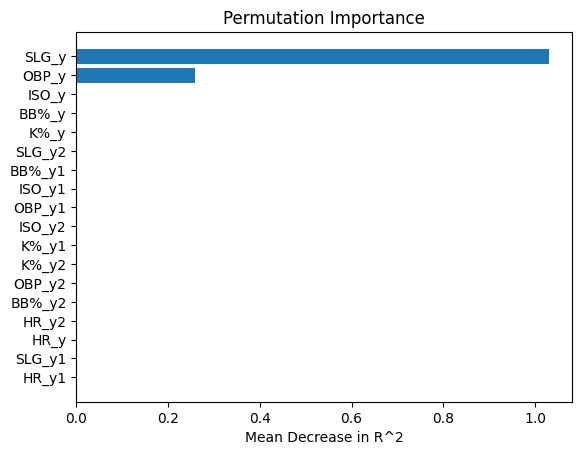

In [14]:
# Permutation Importance using sklearn
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_train.numpy(), y_train.numpy().flatten())
result = permutation_importance(
    lr_model, X_test.numpy(), y_test.numpy().flatten(), n_repeats=10, random_state=42
)

sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(np.array(features)[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.xlabel("Mean Decrease in R^2")
plt.gca().invert_yaxis()
plt.show()


### Step 4: SHAP Values

In [ ]:
# SHAP values
explainer = shap.Explainer(models[0], X_test.numpy())
shap_values = explainer(X_test.numpy())

shap.plots.beeswarm(shap_values)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /Users/ak11/Desktop/Miscellaneous/Projects/baseball/mlb-performance-predictor/.venv/lib/python3.11/site-packages/shap/maskers/_tabular.py (203)

File "../.venv/lib/python3.11/site-packages/shap/maskers/_tabular.py", line 203:
def _single_delta_mask(dind, masked_inputs, last_mask, data, x, noop_code):
    <source elided>

@njit
^

During: Pass nopython_type_inference 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'torch.Tensor'>


**SHAP Explanation:** SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. It’s based on cooperative game theory and tells you how much each feature pushed a prediction up or down.

**Permutation Importance Explanation:** It measures how much a feature contributes to a model's performance by randomly shuffling it and observing the drop in model accuracy. A bigger drop means more importance.